# Prendre en main l'API Python d'ArcGIS - épisode 9
## Intoduction au Deep Learning : Entraînement d'un modèle


Dans cet ultime épisode de notre [série consacrée à l'API Python d'ArcGIS](https://www.codethemap.fr/2024/05/prise-en-main-api-python-arcgis-intro.html), je vous propose de découvrir une introduction au Deep Learning avec le module [`arcgis.learn`](https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html) de l'API. De nombreux modèles de Deep Learning sont disponibles, permettant notamment d'extraire différents types d'objets à partir d'images satellites. Quand vous utilisez un modèle de Deep Learning, il est mieux de l'entraîner préalablement afin de l'adapter à vos données. Dans ce tutoriel, nous allons voir comment utiliser l'API pour entraîner un modèle classification de pixels spécialisé dans la reconnaissance de routes qui permettra d'extraire des routes à partir d'imagerie satellite. Les modèles entraînés peuvent ensuite être utilisés directement dans ArcGIS Pro ou ArcGIS Enterprise, et supportent les traitement distribués pour obtenir des résultats plus rapides.

Si vous utilisez ArcGIS Notebooks, il est préconisé d'utiliser le runtime *Avancé avec prise en charge du GPU*.

### 0/ Présentation et pre-processing des données

Dans ce tutoriel, nous récupèrerons directement les données pré-processées publiées publiquement sur ArcGIS Online. Cependant, vous retrouverez ci-dessous la description des étapes de préparation des données.

Pour ce tutoriel, nous utiliserons un sous-ensemble du [jeu de données SpaceNet](https://spacenet.ai/spacenet-roads-dataset/) accessible au public. Les étiquettes vectorielles des axes routiers peuvent être téléchargées avec les données d'imagerie, hébergées sur AWS S3 (*le jeu de données SpaceNet utilisé dans ce tutoriel est placé sous la licence [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/)*).  
La zone d'étude est Paris, avec 425 km de longueur d'axes routiers. Deux entrées sont utilisées pour créer les données nécessaires à l'apprentissage du modèle :une couche d'imagerie et la couche vectorielle (permettant de créer les labels et les fragments d'image).  
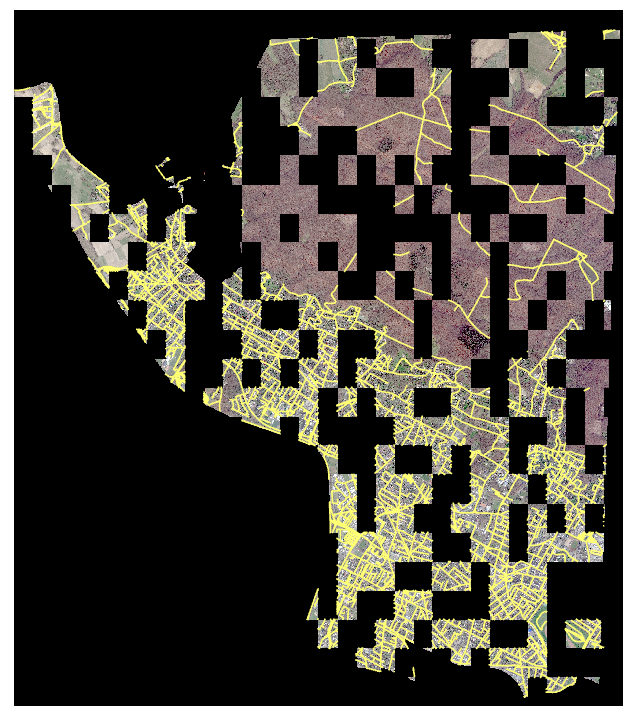

Les données téléchargées comportent 4 types d'imagerie : Multispectral, Pan, Pan-sharpened Multispectral, Pan-sharpened RGB. Dans ce tutoriel, nous utiliserons les données Pan-sharpened RGB converties en imagerie 8 bit.

Les données on été pré-traîtées grâce à ArcGIS Pro selon les étapes suivantes :
- Les labels vecteurs au format .geojson ont été converties en feature class ([outil JSON vers entités](https://pro.arcgis.com/fr/pro-app/latest/tool-reference/conversion/json-to-features.htm)) ;
- La donnée vecteur convertie est vérifiée et réparée si des géométries invalides sont trouvées ([outil Réparer les géométries](https://pro.arcgis.com/fr/pro-app/latest/tool-reference/data-management/repair-geometry.htm)) ;
- L'imagerie est convertie de donnée 16-bit vers 8-bit ([fonction Etirer](https://pro.arcgis.com/fr/pro-app/latest/help/analysis/raster-functions/stretch-function.htm)) ;
- Un système de coordonées projeté est appliqués aux données d'imagerie et aux données vecteurs afin de faciliter l'interprétation des résultats et les valeurs utilisées pour les paramètres des outils.

Les données sont maintenant prête à être [exportées en tant que données d'entraînement pour le Deep Learning](https://pro.arcgis.com/fr/pro-app/latest/tool-reference/image-analyst/export-training-data-for-deep-learning.htm).

Ici, les données ont été exportées au format 'Classified Tiles (tuiles classées)' en utilisant une taille de cellule de '30 cm'. La taille de la tuile X et la taille de la tuile Y sont réglées sur '512', tandis que le Pas en  X et le Pas en Y sont réglées sur « 128 ».  
Si les axes routiers sont directement utilisés comme données d'entrée, la taille de la zone tampon peut être définie en fonction de la zone d'intérêt et des types de routes dans cette région. Il est également possible d'utiliser [l'outil Créer des zones tampons](https://pro.arcgis.com/fr/pro-app/latest/tool-reference/feature-analysis/create-buffers.htm) pour convertir les lignes représantant les axes routiers en polygones routiers et la valeur de la zone tampon peut être déterminée de manière itérative en vérifiant les résultats de l'outil.  
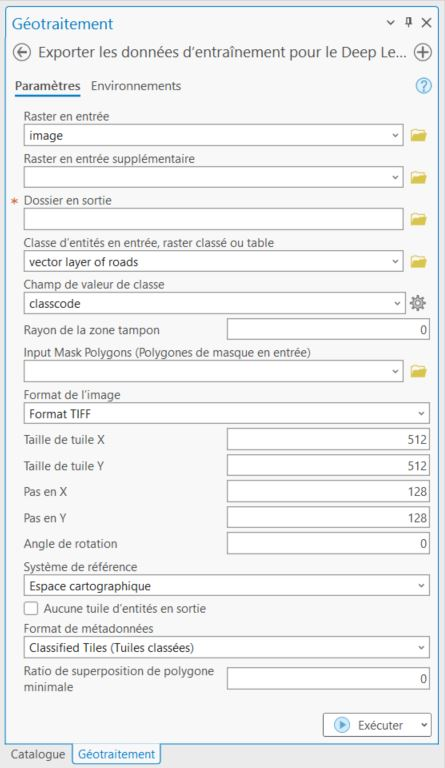

Les données publiées sont partagées dans [cet item ArcGIS](https://www.arcgis.com/home/item.html?id=b7bbf2f5f4184960890afeabbdb51a32), auquel nous allons accéder pour la suite du tutoriel.

### 1/ Préparation des données

Nous commençons par importer les différentes bibliothèques qui seront nécessaires. Notez particulièrement l'import de [`prepare_data()`](https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html#prepare-data) et du modèle de Deep Learning [`MultiTaskRoadExtractor`](https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html#multitaskroadextractor) issus d'[`arcgis.learn`](https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html).

In [2]:
import os, zipfile
from pathlib import Path

from arcgis.learn import prepare_data, MultiTaskRoadExtractor
from arcgis.gis import GIS
gis = GIS('home')

You are logged on as plouis_esrifrance with an administrator role, proceed with caution.


Nous accédons ensuite aux données qui nous permettront d'entraîner notre modèle, issues des étapes décrites précédemment :

<Item title:"automatic_road_extraction_using_deep_learning" type:Image Collection owner:api_data_owner>
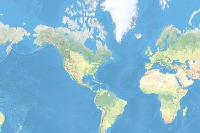

In [3]:
training_data = gis.content.get('b7bbf2f5f4184960890afeabbdb51a32')
training_data

Nous allons télécharger ces données, les extraires et en récupérer le chemin d'accès :

In [4]:
filepath = training_data.download(file_name=training_data.name)

In [5]:
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [6]:
output_path = Path(os.path.join(os.path.splitext(filepath)[0]))

Nous allons maintenant pouvoir exécuter la fonction [`prepare_data()`](https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html#prepare-data). Voici les arguments fréquemment utilisés :
- `path` : chemin vers le fichier contenant les données d'entraînement ;
- `chip_size` : les images seront recadrées selon le chip_size spécifié ;
- `batch_size` : nombre d'image que le modèle va entraîner à chaque étape d'un epoch, cela dépend directement de la mémoire de votre carte graphique ;
- `val_split_pct` : pourcentage de données à garder pour la validation du modèle ;
- `resize_to` : redimensionne les images recadrées à la taille indiquée.

In [7]:
data = prepare_data(output_path, chip_size=512, batch_size=4)

### 2/ Visualisation des données préparées

Nous pouvons maintenant jeter un oeil aux données préparées, en regardant l'imagerie ainsi que les labels qui y sont superposés avec la `show_batch()`. Le paramètre `alpha` permet de contrôler la transparence des labels.

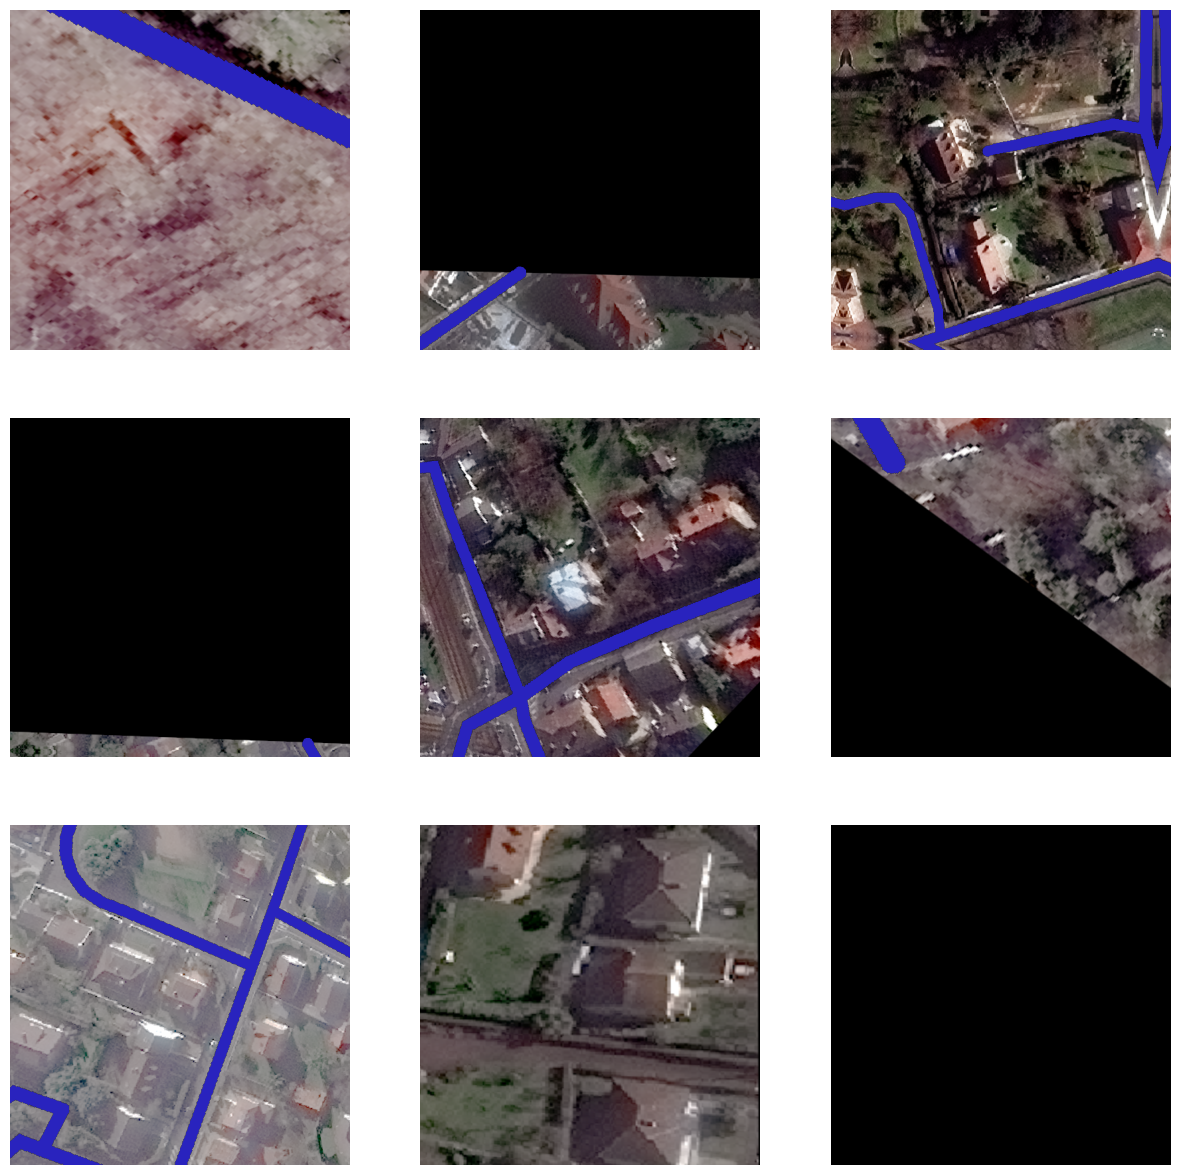

In [9]:
data.show_batch(alpha=1)

### 3/ Entrainement du modèle

Nous allons maintenant pouvoir passer à l'entrainement du modèle.  
Nous commençons par créer un objet contenant le modèle Multi-Task Road Extractor , en utilisant les données préparées. Des paramètres avancés spécifiques au modèle peuvent être définis à ce moment, mais notez qu'ils sont optionnels, et que les valeurs définies par défaut fonctionnent de manière satisfaisante dans la plupart des cas.
Voici la liste des paramètres avancés pour le modèle Multi-Task Road Extractor :
- `gaussian_thresh` : définit le seuil gaussien qui permet de fixer la largeur de route requise.
- `orient_bin_size` : définit la taille de la boîte pour les angles d'orientation.
- `orient_theta` : définit la largeur du masque d'orientation.
- `mtl_model` : définit l'architecture neuronale du modèle. Les valeurs possibles sont « linknet » et « hourglass ».

In [10]:
model = MultiTaskRoadExtractor(data, mtl_model="hourglass")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/arcgis/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Nous utilisons ensuite la fonction [`lr_find()`](https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html#arcgis.learn.MultiTaskRoadExtractor.lr_find) pour trouver le taux d'apprentissage (learning rate) optimal. Ce taux d'apprentissage contrôle la vitesse à laquelle les informations existantes seront écrasées par les nouvelles informations acquises tout au long du processus de formation. Si aucune valeur n'est spécifiée, le taux d'apprentissage optimal sera extrait de la courbe d'apprentissage pendant le processus de formation.

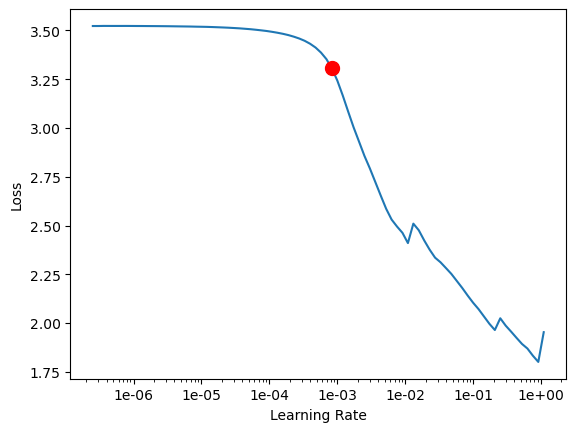

In [11]:
lr = model.lr_find()

In [12]:
lr

0.0008317637711026709

C'est la méthode [`fit()`](https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html#arcgis.learn.MultiTaskRoadExtractor.fit) qui va nous permettre d'entraîner le modèle. Nous passons en argument le taux d'apprentissage calculé juste avant. Si le paramètre `early_stopping` est défini à `True`, l'entraînement du modèle va s'arrêter dès que le modèle arrête de s'améliorer, quel que soit la valeur spécifiée pour le paramètre `epoch` (ici 50). Un epoch signifie signifie que l'ensemble de données est fait un aller-retour dans le réseau neuronal. `miou` et `dice` sont des métriques de performance, qui s'afficheront après la complétion de chaque epoch.

In [13]:
model.fit(50, lr, early_stopping=True)

Epoch 49: early stopping


### 4/ Visualisation des résultats

Nous allons maintenant visualiser les résultats avec la méthode [`show_results()`](https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html#arcgis.learn.MultiTaskRoadExtractor.fit) en utilisant les données de validation. La première colonne montre les "ground truth image" auxquelles se superpose les "ground truth labels", tandis que la seconde montre les "ground truth image" auxquelles se superposent les "predicted labels", c'est-à-dire les routes que le modèle aura détectées. 

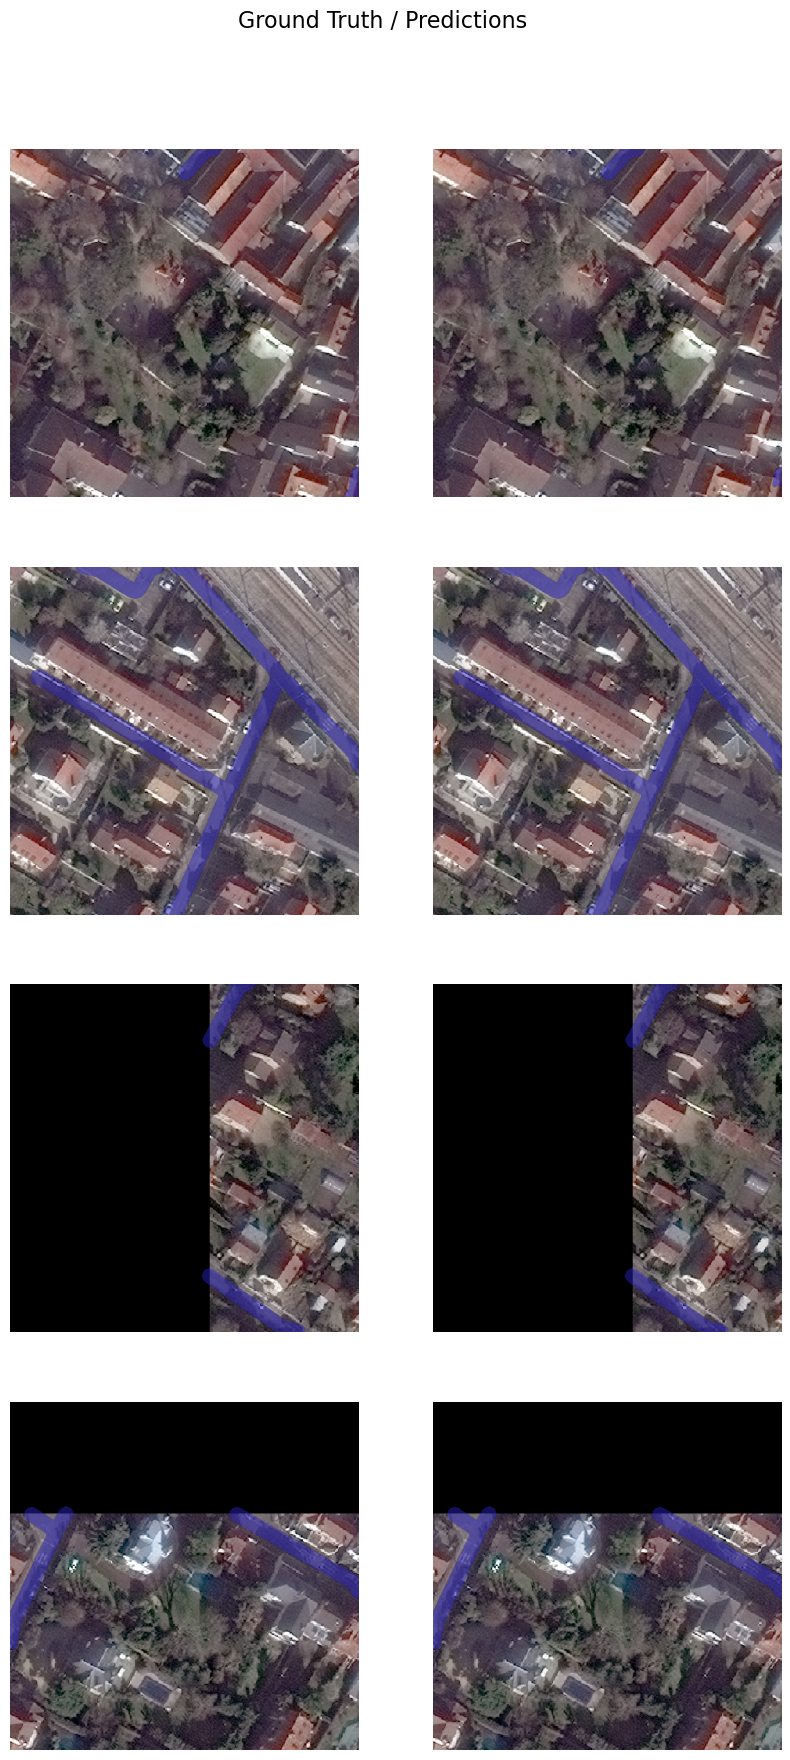

In [14]:
model.show_results(rows=4)

### 5/ Enregistrement du modèle

La dernière étape est de sauvegarder le modèle entraîné avec la méthode [`save()`](https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html#arcgis.learn.MultiTaskRoadExtractor.save). Vous pouvez spécifier un chemin d'accès ainsi que le nom du modèle. Cela va créer un Esri Model Definition ainsi qu'un zip contenant un Deep Learning Package vous permettant de le déployer sur Image Server ou sur ArcGIS Pro.

In [15]:
model.save('road_model_for_spacenet_data')

Computing model metrics...


PosixPath('/tmp/automatic_road_extraction_using_deep_learning/models/road_model_for_spacenet_data')

### 6/ Utilisation du modèle

Vous pouvez maintenant extraire les routes sur des [jeux de données SpaceNet] en utilisant le modèle sauvegardé à l'étape précendente, par exemple dans ArcGIS Pro en utilisant le modèle dans [l'outil Classer des pixels à l’aide du Deep Learning](https://pro.arcgis.com/fr/pro-app/latest/tool-reference/image-analyst/classify-pixels-using-deep-learning.htm). Cela créera un raster classifié pouvant être ensuite converti en couche vecteur contenant les routes.  
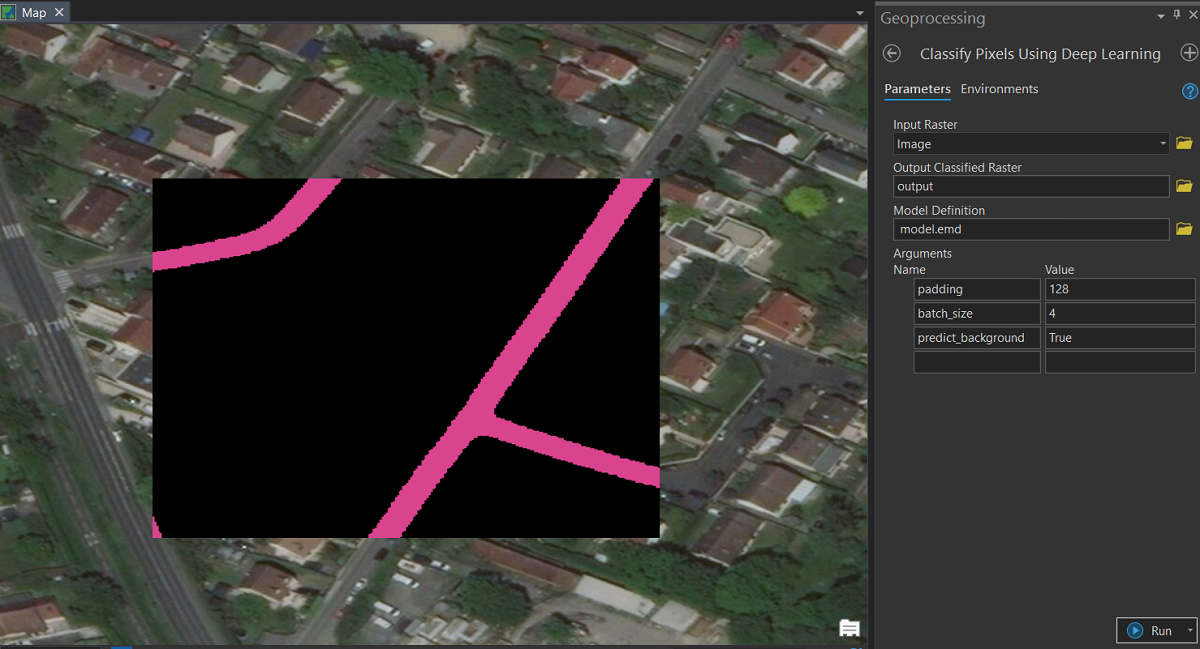

Nous avons vu les étapes basiques pour la préparation d'un modèle de Deep Learning : préparation des données, création du modèle, définition du taux d'apprentissage, entraînement du modèle, examination des résultats, sauvegarde du modèle. Ces étapes d'entraînement sont nécessaires afin que le modèle fonctionne de manière efficace avec vos données. Le module [`arcgis.learn`](https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html) possède de nombreux autres modèles que je vous invite à découvrir.

C'est ainsi que ce terminent cette série de tutoriels sur l'API Python, mais je vous invite à [redécouvrir tous les épisodes](https://www.codethemap.fr/2024/05/prise-en-main-api-python-arcgis-intro.html) pour être sûrs de ne pas en avoir manqué un seul. Et si vous êtes incollable sur Python et que vous souhaitez vous lancer dans une autre aventure, n'hésitez pas à découvrir [une autre série se concentrant sur l'API JavaScript d'ArcGIS](https://www.codethemap.fr/2023/07/prise-en-main-de-lapi-javascript-intro.html).